In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk integrasi dengan Tableau
import json

In [2]:
df = pd.read_csv('/content/Hasil_Penerbangan_Finall_backup_before_augment.csv')

In [12]:
df.head()

,Tanggal_Penerbangan,Hari,Maskapai,Nomor_Penerbangan,Bandara_Asal,Kode_IATA_Asal,Bandara_Tujuan,Kode_IATA_Tujuan,Jadwal_Keberangkatan,Jadwal_Kedatangan,...,Suhu_Celcius_tujuan,Kelembaban_%_tujuan,Tekanan_hPa_tujuan,Kecepatan_Angin_m/s_tujuan,Kecepatan_Angin_km_jam_tujuan,Kota_Asal,Rute,Durasi_Actual,Durasi_Normal,Keterlambatan_Kedatangan
0,2025-07-28,Senin,Batik Air,ID6288,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 00:10:00,2025-07-28 03:30:00,...,27.5,66,1012,3.2,11.52,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
1,2025-07-28,Senin,Sriwijaya Air,SJ592,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 00:30:00,2025-07-28 03:55:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,205.0,200.0,5.0
2,2025-07-28,Senin,Citilink,QG346,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:10:00,2025-07-28 04:30:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
3,2025-07-28,Senin,Lion Air,JT898,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:30:00,2025-07-28 04:50:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
4,2025-07-28,Senin,Lion Air,JT986,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:30:00,2025-07-28 04:50:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,200.0,200.0,0.0


In [3]:
# Konversi kecepatan angin dari m/s ke km/jam
df['Kecepatan_Angin_km_jam_tujuan'] = df['Kecepatan_Angin_m/s_tujuan'] * 3.6


In [4]:
# Buat kolom kota asal (diasumsikan selalu Jakarta dari Soekarno-Hatta International)
rute_mapping = {'Soekarno-Hatta International': 'Jakarta'}
df['Kota_Asal'] = df['Bandara_Asal'].map(rute_mapping).fillna(df['Bandara_Asal'])

In [5]:
# Buat kolom rute dalam format 'Asal-Tujuan'
df['Rute'] = df['Kota_Asal'] + '-' + df['Kota_tujuan']

# Ubah format tanggal keberangkatan dan kedatangan ke datetime
df['Jadwal_Keberangkatan'] = pd.to_datetime(df['Jadwal_Keberangkatan'])
df['Jadwal_Kedatangan'] = pd.to_datetime(df['Jadwal_Kedatangan'])

In [6]:
# Hitung durasi actual dalam menit
df['Durasi_Actual'] = (df['Jadwal_Kedatangan'] - df['Jadwal_Keberangkatan']).dt.total_seconds() / 60

In [7]:
# Definisikan durasi normal rute dalam menit
normal_duration_map = {
    "Jakarta-Padang": 110,
    "Jakarta-Surabaya": 80,
    "Jakarta-Bali": 170,
    "Jakarta-Makassar": 200
}

# Tambahkan kolom durasi normal sesuai rute
df['Durasi_Normal'] = df['Rute'].map(normal_duration_map)

In [8]:
# Hitung keterlambatan kedatangan = durasi actual - durasi normal
df['Keterlambatan_Kedatangan'] = df['Durasi_Actual'] - df['Durasi_Normal']

# Hapus baris dengan data hilang pada durasi normal dan keterlambatan
df_model = df.dropna(subset=['Durasi_Normal', 'Keterlambatan_Kedatangan'])

In [9]:
# Encoding tanggal penerbangan ke ordinal
df_model['Tanggal_Ordinal'] = pd.to_datetime(df_model['Tanggal_Penerbangan']).map(pd.Timestamp.toordinal)

# Encoding kategori menggunakan LabelEncoder
label_encoders = {}
for col in ['Maskapai', 'Rute', 'Deskripsi_tujuan']:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

/tmp/ipython-input-1960816930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Tanggal_Ordinal'] = pd.to_datetime(df_model['Tanggal_Penerbangan']).map(pd.Timestamp.toordinal)
/tmp/ipython-input-1960816930.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
/tmp/ipython-input-1960816930.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [10]:
# Pilih fitur dan target
feature_cols = ['Tanggal_Ordinal', 'Maskapai_encoded', 'Rute_encoded', 'Deskripsi_tujuan_encoded',
                'Suhu_Celcius_tujuan', 'Tekanan_hPa_tujuan', 'Kecepatan_Angin_km_jam_tujuan']
X = df_model[feature_cols]
y = df_model['Keterlambatan_Kedatangan']

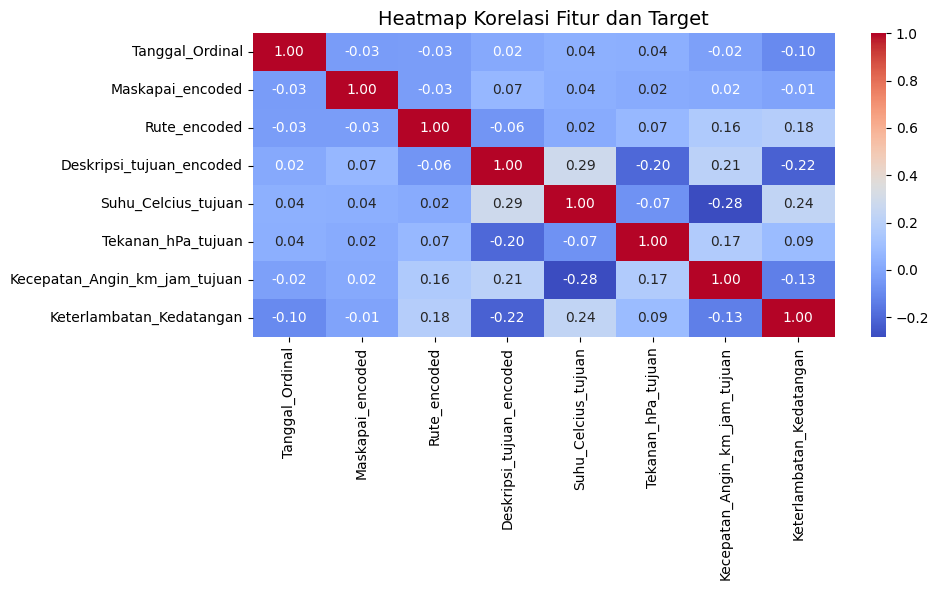

In [11]:
# Gabungkan fitur dan target ke satu dataframe untuk korelasi
df_corr = X.copy()
df_corr['Keterlambatan_Kedatangan'] = y

# Hitung korelasi
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap Korelasi Fitur dan Target", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# ====================================
# Split data 80:20
# ====================================
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_model_80_20 = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model_80_20.fit(X_train_80, y_train_80)

# ====================================
# Split data 70:30
# ====================================
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf_model_70_30 = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model_70_30.fit(X_train_70, y_train_70)

# ====================================
# Split data 60:40
# ====================================
X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(
    X, y, test_size=0.4, random_state=42
)

rf_model_60_40 = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model_60_40.fit(X_train_60, y_train_60)


RandomForestRegressor(n_estimators=300, random_state=42)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test, split_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Evaluasi Model ({split_name})")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print("-" * 40)

# Evaluasi model untuk setiap skenario split
evaluate_model(rf_model_80_20, X_test_20, y_test_20, "80:20")
evaluate_model(rf_model_70_30, X_test_30, y_test_30, "70:30")
evaluate_model(rf_model_60_40, X_test_40, y_test_40, "60:40")


Evaluasi Model (80:20)
MAE  : 5.4058
RMSE : 30.9550
R²   : 0.9828
----------------------------------------
Evaluasi Model (70:30)
MAE  : 9.1889
RMSE : 55.0579
R²   : 0.9392
----------------------------------------
Evaluasi Model (60:40)
MAE  : 13.8486
RMSE : 105.7742
R²   : 0.7614
----------------------------------------


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
import pandas as pd

# Fungsi evaluasi model
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

# Hyperparameter grid untuk tuning
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

splits = {
    "80:20": 0.2,
    "70:30": 0.3,
    "60:40": 0.4
}

results = []

for split_name, test_size in splits.items():
    print(f"\n=== Split {split_name} ===")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Baseline model
    rf_baseline = RandomForestRegressor(n_estimators=300, random_state=42)
    rf_baseline.fit(X_train, y_train)
    mae_b, rmse_b, r2_b = evaluate(rf_baseline, X_test, y_test)

    # Tuning model
    rf = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=20,
        cv=3,
        verbose=0,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    mae_t, rmse_t, r2_t = evaluate(best_model, X_test, y_test)

    # Simpan hasil
    results.append([split_name, "Sebelum Tuning", mae_b, rmse_b, r2_b])
    results.append([split_name, "Sesudah Tuning", mae_t, rmse_t, r2_t])

# Buat dataframe hasil
df_results = pd.DataFrame(results, columns=["Split", "Model", "MAE", "RMSE", "R²"])
print("\n=== Hasil Evaluasi ===")
print(df_results)



=== Split 80:20 ===

=== Split 70:30 ===

=== Split 60:40 ===

=== Hasil Evaluasi ===
   Split           Model        MAE        RMSE        R²
0  80:20  Sebelum Tuning   5.405805   30.954972  0.982798
1  80:20  Sesudah Tuning  17.326410  106.827250  0.795124
2  70:30  Sebelum Tuning   9.188874   55.057865  0.939166
3  70:30  Sesudah Tuning  18.226956  105.027920  0.778632
4  60:40  Sebelum Tuning  13.848590  105.774198  0.761377
5  60:40  Sesudah Tuning  23.906788  122.768218  0.678542


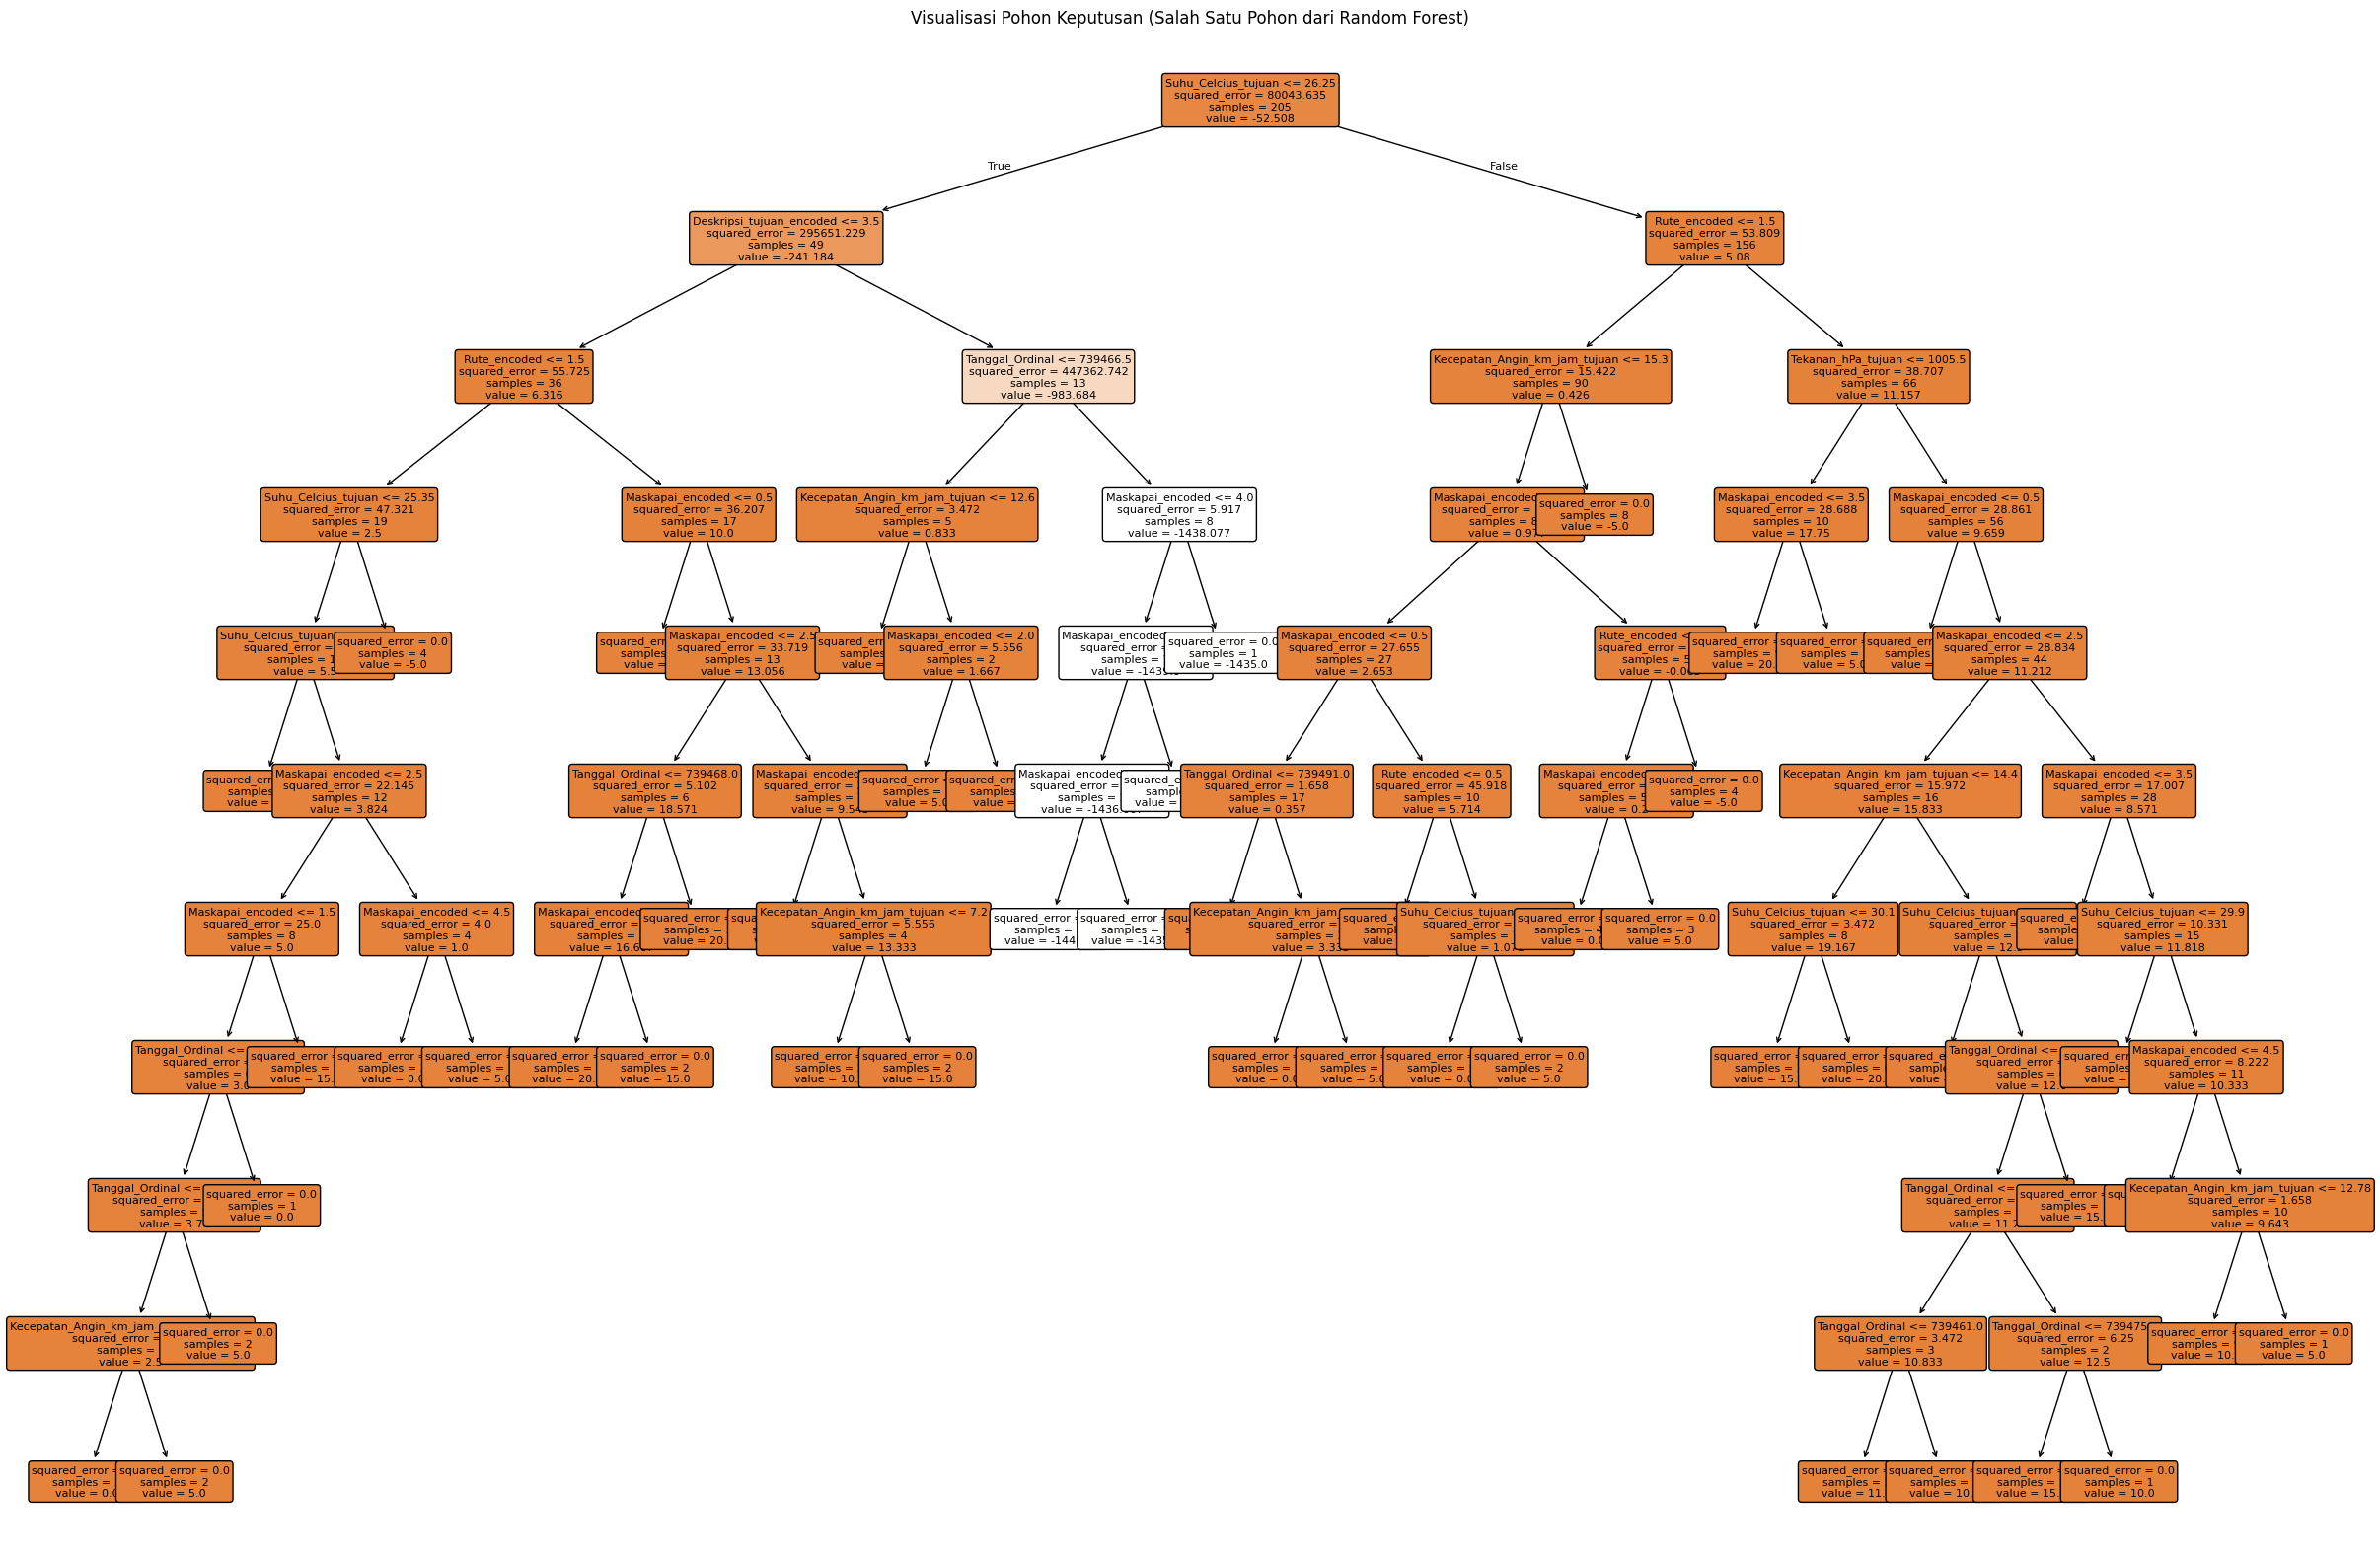

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Ambil salah satu pohon dari Random Forest (misalnya estimator ke-0)
estimator = rf_baseline.estimators_[299]

plt.figure(figsize=(30, 20))
plot_tree(estimator,
          filled=True,
          feature_names=X.columns,
          rounded=True,
          fontsize=8)
plt.title("Visualisasi Pohon Keputusan (Salah Satu Pohon dari Random Forest)")
plt.show()


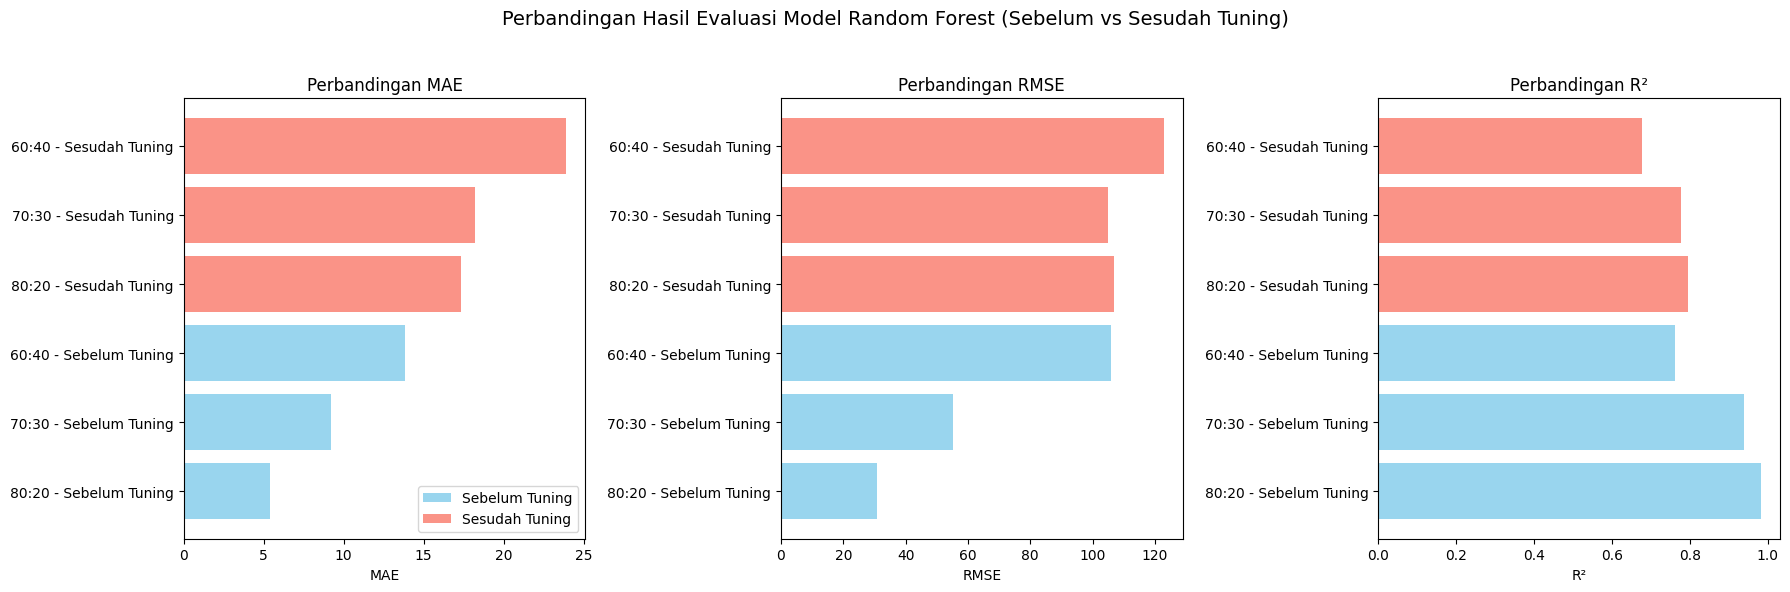

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Data hasil evaluasi
df_results = pd.DataFrame({
    "Split": ["80:20", "80:20", "70:30", "70:30", "60:40", "60:40"],
    "Model": ["Sebelum Tuning", "Sesudah Tuning", "Sebelum Tuning", "Sesudah Tuning", "Sebelum Tuning", "Sesudah Tuning"],
    "MAE": [5.405805, 17.326410, 9.188874, 18.226956, 13.848590, 23.906788],
    "RMSE": [30.954972, 106.827250, 55.057865, 105.027920, 105.774198, 122.768218],
    "R²": [0.982798, 0.795124, 0.939166, 0.778632, 0.761377, 0.678542]
})

# Warna
colors = {"Sebelum Tuning": "skyblue", "Sesudah Tuning": "salmon"}
metrics = ["MAE", "RMSE", "R²"]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for model_type in df_results["Model"].unique():
        subset = df_results[df_results["Model"] == model_type]
        ax.barh(subset["Split"] + " - " + model_type, subset[metric],
                color=colors[model_type], alpha=0.85,
                label=model_type if i == 0 else "")
    ax.set_title(f"Perbandingan {metric}")
    ax.set_xlabel(metric)

axes[0].legend()
plt.suptitle("Perbandingan Hasil Evaluasi Model Random Forest (Sebelum vs Sesudah Tuning)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np

# ==============================
# 1. Split data (80:20 contoh)
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# 2. Model Baseline (Sebelum Tuning)
# ==============================
rf_baseline = RandomForestRegressor(n_estimators=200, random_state=42)
rf_baseline.fit(X_train, y_train)

# Evaluasi baseline
y_pred_baseline = rf_baseline.predict(X_test)
mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_base = r2_score(y_test, y_pred_baseline)

print("=== Evaluasi Sebelum Tuning (Baseline) ===")
print(f"MAE  : {mae_base:.4f}")
print(f"RMSE : {rmse_base:.4f}")
print(f"R²   : {r2_base:.4f}")
print("-"*40)

# ==============================
# 3. Model Setelah Tuning (RandomizedSearchCV)
# ==============================
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_tuned = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_tuned,
    param_distributions=param_grid,
    n_iter=20,  # jumlah kombinasi yang dicoba
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best model hasil tuning
best_model = random_search.best_estimator_

# Evaluasi setelah tuning
y_pred_tuned = best_model.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("=== Evaluasi Sesudah Tuning ===")
print(f"MAE  : {mae_tuned:.4f}")
print(f"RMSE : {rmse_tuned:.4f}")
print(f"R²   : {r2_tuned:.4f}")
print("-"*40)

# ==============================
# 4. Tabel Perbandingan
# ==============================
import pandas as pd

results = pd.DataFrame({
    "Model": ["Sebelum Tuning", "Sesudah Tuning"],
    "MAE": [mae_base, mae_tuned],
    "RMSE": [rmse_base, rmse_tuned],
    "R²": [r2_base, r2_tuned]
})

print(results)


=== Evaluasi Sebelum Tuning (Baseline) ===
MAE  : 5.3830
RMSE : 31.9652
R²   : 0.9817
----------------------------------------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
=== Evaluasi Sesudah Tuning ===
MAE  : 17.3264
RMSE : 106.8272
R²   : 0.7951
----------------------------------------
            Model        MAE        RMSE        R²
0  Sebelum Tuning   5.383012   31.965226  0.981656
1  Sesudah Tuning  17.326410  106.827250  0.795124


In [51]:
# Prediksi keterlambatan pada data test dan seluruh data
predictions_test = rf_model_80_20.predict(X_test)
predictions_all = rf_model_80_20.predict(X)

In [ ]:
# Evaluasi model
mae = mean_absolute_error(y_test, predictions_test)
print(f'Mean Absolute Error: {mae:.2f} menit')

Mean Absolute Error: 5.38 menit


In [52]:
# Tambahkan kolom prediksi ke df_model
df_model['Prediksi_Keterlambatan'] = predictions_all

# Hitung waktu prediksi kedatangan = jadwal keberangkatan + durasi normal + prediksi keterlambatan (menit)
df_model['Waktu_Prediksi_Kedatangan'] = df_model['Jadwal_Keberangkatan'] + \
                                        pd.to_timedelta(df_model['Durasi_Normal'] + df_model['Prediksi_Keterlambatan'], unit='m')

/tmp/ipython-input-2343406799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Prediksi_Keterlambatan'] = predictions_all
/tmp/ipython-input-2343406799.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Waktu_Prediksi_Kedatangan'] = df_model['Jadwal_Keberangkatan'] + \


In [56]:
# Buat kalimat prediksi untuk tiap baris
def buat_kalimat_prediksi(row):
    if row['Prediksi_Keterlambatan'] > 1:
        return f"{row['Maskapai']} diprediksi mengalami keterlambatan kedatangan sekitar {int(row['Prediksi_Keterlambatan'])} menit yaitu pukul {row['Waktu_Prediksi_Kedatangan'].strftime('%H:%M:%S')}"
    else:
        return f"{row['Maskapai']} diprediksi kedatangan tepat waktu yaitu pukul {row['Waktu_Prediksi_Kedatangan'].strftime('%H:%M:%S')}"

df_model['Prediksi_Text'] = df_model.apply(buat_kalimat_prediksi, axis=1)

/tmp/ipython-input-1033870780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Prediksi_Text'] = df_model.apply(buat_kalimat_prediksi, axis=1)


In [58]:
# Contoh menampilkan prediksi untuk setiap tanggal unik yang ada
for tanggal in sorted(df_model['Tanggal_Penerbangan'].unique()):
    print(f"Prediksi keterlambatan untuk tanggal {tanggal}:")
    contoh_prediksi = df_model[df_model['Tanggal_Penerbangan'] == tanggal]['Prediksi_Text'].head(5).tolist()
    for kalimat in contoh_prediksi:
        print(kalimat)
    print('\n')

Prediksi keterlambatan untuk tanggal 2025-07-28:
Batik Air diprediksi kedatangan tepat waktu yaitu pukul 03:30:09
Sriwijaya Air diprediksi mengalami keterlambatan kedatangan sekitar 3 menit yaitu pukul 03:53:46
Citilink diprediksi mengalami keterlambatan kedatangan sekitar 1 menit yaitu pukul 04:31:45
Lion Air diprediksi kedatangan tepat waktu yaitu pukul 04:50:15
Lion Air diprediksi kedatangan tepat waktu yaitu pukul 04:50:15


Prediksi keterlambatan untuk tanggal 2025-07-29:
Batik Air diprediksi kedatangan tepat waktu yaitu pukul 03:25:25
Sriwijaya Air diprediksi mengalami keterlambatan kedatangan sekitar 4 menit yaitu pukul 03:54:55
Citilink diprediksi kedatangan tepat waktu yaitu pukul 04:30:33
Lion Air diprediksi kedatangan tepat waktu yaitu pukul 04:50:00
Lion Air diprediksi kedatangan tepat waktu yaitu pukul 04:50:00


Prediksi keterlambatan untuk tanggal 2025-07-30:
Batik Air diprediksi kedatangan tepat waktu yaitu pukul 17:50:13
Batik Air diprediksi kedatangan tepat waktu yait

In [ ]:
df.head(20)

,Tanggal_Penerbangan,Hari,Maskapai,Nomor_Penerbangan,Bandara_Asal,Kode_IATA_Asal,Bandara_Tujuan,Kode_IATA_Tujuan,Jadwal_Keberangkatan,Jadwal_Kedatangan,...,Suhu_Celcius_tujuan,Kelembaban_%_tujuan,Tekanan_hPa_tujuan,Kecepatan_Angin_m/s_tujuan,Kecepatan_Angin_km_jam_tujuan,Kota_Asal,Rute,Durasi_Actual,Durasi_Normal,Keterlambatan_Kedatangan
0,2025-07-28,Senin,Batik Air,ID6288,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 00:10:00,2025-07-28 03:30:00,...,27.5,66,1012,3.2,11.52,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
1,2025-07-28,Senin,Sriwijaya Air,SJ592,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 00:30:00,2025-07-28 03:55:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,205.0,200.0,5.0
2,2025-07-28,Senin,Citilink,QG346,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:10:00,2025-07-28 04:30:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
3,2025-07-28,Senin,Lion Air,JT898,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:30:00,2025-07-28 04:50:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
4,2025-07-28,Senin,Lion Air,JT986,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:30:00,2025-07-28 04:50:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
5,2025-07-28,Senin,Lion Air,JT3896,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:30:00,2025-07-28 04:50:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,200.0,200.0,0.0
6,2025-07-28,Senin,Lion Air,JT868,Soekarno-Hatta International,CGK,Juanda,SUB,2025-07-28 03:30:00,2025-07-28 04:55:00,...,24.1,87,1013,3.0,10.80,Jakarta,Jakarta-Surabaya,85.0,80.0,5.0
7,2025-07-28,Senin,Lion Air,JT690,Soekarno-Hatta International,CGK,Juanda,SUB,2025-07-28 03:30:00,2025-07-28 04:55:00,...,24.1,87,1013,3.0,10.80,Jakarta,Jakarta-Surabaya,85.0,80.0,5.0
8,2025-07-28,Senin,Lion Air,JT748,Soekarno-Hatta International,CGK,Juanda,SUB,2025-07-28 03:30:00,2025-07-28 04:55:00,...,24.1,87,1013,3.0,10.80,Jakarta,Jakarta-Surabaya,85.0,80.0,5.0
9,2025-07-28,Senin,Garuda Indonesia,GA604,Soekarno-Hatta International,CGK,Hasanudin,UPG,2025-07-28 01:35:00,2025-07-28 05:10:00,...,24.7,64,1006,2.7,9.72,Jakarta,Jakarta-Makassar,215.0,200.0,15.0


In [ ]:
df.to_csv('Hasil_Uji_Data.csv')

In [ ]:
import joblib

# Setelah model dilatih seperti sebelumnya
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

# Simpan model ke file .joblib
model_filename = 'model_random_forest_keterlambatan.joblib'
joblib.dump(rf_model, model_filename)

print(f'Model berhasil disimpan ke file {model_filename}')


Model berhasil disimpan ke file model_random_forest_keterlambatan.joblib


In [ ]:
# Simpan encoder ke file
joblib.dump(le, f'label_encoder_{col}.joblib')

['label_encoder_Deskripsi_tujuan.joblib']

In [ ]:
import joblib

# Muat model
rf_model = joblib.load('model_random_forest_keterlambatan.joblib')

# Muat LabelEncoder from the dictionary
le_maskapai = label_encoders['Maskapai']
le_rute = label_encoders['Rute']
le_deskripsi = label_encoders['Deskripsi_tujuan']

In [ ]:
# Gabungkan model dan encoder ke dalam satu dictionary
model_package = {
    'model': rf_model,
    'label_encoders': label_encoders
}

# Simpan ke file .joblib
filename = 'model_dan_encoders.joblib'
joblib.dump(model_package, filename)

['model_dan_encoders.joblib']

In [ ]:
# Group by Maskapai and then find unique origin and destination pairs for each airline
routes_by_maskapai = df.groupby('Maskapai').apply(lambda x: x[['Bandara_Asal', 'Bandara_Tujuan']].drop_duplicates().values.tolist())

print("Routes for each airline:")
for maskapai, routes in routes_by_maskapai.items():
    print(f"\nAirline: {maskapai}")
    for route in routes:
        print(f"- {route[0]} to {route[1]}")

Routes for each airline:

Airline: AirAsia
- Soekarno-Hatta International to Ngurah Rai International

Airline: Batik Air
- Soekarno-Hatta International to Hasanudin
- Soekarno-Hatta International to Juanda
- Soekarno-Hatta International to Ngurah Rai International

Airline: Citilink
- Soekarno-Hatta International to Hasanudin
- Soekarno-Hatta International to Juanda
- Soekarno-Hatta International to Ngurah Rai International
- Soekarno-Hatta International to Minangkabau International Airport

Airline: Garuda Indonesia
- Soekarno-Hatta International to Hasanudin
- Soekarno-Hatta International to Juanda
- Soekarno-Hatta International to Ngurah Rai International
- Soekarno-Hatta International to Minangkabau International Airport

Airline: Lion Air
- Soekarno-Hatta International to Hasanudin
- Soekarno-Hatta International to Juanda
- Soekarno-Hatta International to Ngurah Rai International

Airline: Nam Air
- Soekarno-Hatta International to Ngurah Rai International

Airline: Oman Air
- Soe

/tmp/ipython-input-3368500457.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  routes_by_maskapai = df.groupby('Maskapai').apply(lambda x: x[['Bandara_Asal', 'Bandara_Tujuan']].drop_duplicates().values.tolist())
